# Notebook 2: STAC Registration for Walking Data

This notebook runs STAC (Skeletal Tracking with Anatomical Constraints) registration
on the Procrustes-aligned keypoint data from Notebook 1.

**Workflow:**
1. Load aligned keypoints from H5 file (output of Notebook 1)
2. Configure STAC for the fly model
3. Run offset fitting on a subset of frames
4. Run full inverse kinematics (IK) on all frames
5. Optionally interpolate to higher frequency
6. Export joint angles (qpos), velocities (qvel), and body positions (xpos)

## 1. Environment Setup and Imports

In [1]:
# Environment setup (must be before JAX import)
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Adjust GPU as needed

In [2]:
%load_ext autoreload
%autoreload 2

# Standard library
import sys
import warnings
from pathlib import Path

# Scientific computing
import numpy as np
import jax
import jax.numpy as jnp
from scipy import interpolate

# MuJoCo
import mujoco
from mujoco import mjx

# Configuration
from omegaconf import DictConfig, OmegaConf

# Visualization
import matplotlib.pyplot as plt
import mediapy as media

# Progress bars
from tqdm.auto import tqdm

# H5 file I/O
import h5py

# STAC-MJX
import stac_mjx
from stac_mjx import io as stac_io
from stac_mjx.stac import Stac

# JAX cache setup
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

print(f"JAX devices: {jax.devices()}")
print(f"STAC-MJX version: {stac_mjx.__version__ if hasattr(stac_mjx, '__version__') else 'unknown'}")

/home/talmolab/Desktop/SalkResearch/mimic-mjx/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JAX devices: [CudaDevice(id=0)]
STAC-MJX version: unknown


## 2. Configuration

In [3]:
# === PATH CONFIGURATION ===
BASE_PATH = Path("/home/talmolab/Desktop/SalkResearch")
DATA_PATH = BASE_PATH / "data"
STAC_MJX_PATH = BASE_PATH / "stac-mjx"

# Input: Aligned keypoints from Notebook 1
ALIGNED_KP_PATH = DATA_PATH / "aligned_walking_keypoints.h5"

# STAC configuration paths
STAC_CONFIG_DIR = STAC_MJX_PATH / "configs"
MODEL_CONFIG_PATH = STAC_CONFIG_DIR / "model" / "fly_tethered.yaml"
STAC_CONFIG_PATH = STAC_CONFIG_DIR / "stac" / "stac_fly_tethered.yaml"

# Model XML path
MODEL_XML_PATH = STAC_MJX_PATH / "models" / "fruitfly" / "fruitfly_force.xml"

# Output paths
FIT_OFFSETS_PATH = DATA_PATH / "stac_fit_offsets_tethered_fly.h5"
IK_OUTPUT_PATH = DATA_PATH / "stac_ik_output_tethered_fly.h5"

# === STAC PARAMETERS ===
N_FIT_FRAMES = 600  # Number of frames for offset fitting
N_FRAMES_PER_CLIP = 300  # Frames per processing clip (for batching)
INFER_QVELS = True  # Compute joint velocities
TARGET_HZ = 500  # Target frequency for interpolation (None to skip)
SOURCE_HZ = 300  # Source data frequency

# === LOAD PRE-COMPUTED OFFSETS ===
# Set to True to skip offset fitting and load from existing file
LOAD_PRECOMPUTED_OFFSETS = True  # Set to False to recompute offsets

print(f"Aligned keypoints: {ALIGNED_KP_PATH}")
print(f"Model config: {MODEL_CONFIG_PATH}")
print(f"STAC config: {STAC_CONFIG_PATH}")
print(f"Load precomputed offsets: {LOAD_PRECOMPUTED_OFFSETS}")
if LOAD_PRECOMPUTED_OFFSETS:
    print(f"  From: {FIT_OFFSETS_PATH}")

Aligned keypoints: /home/talmolab/Desktop/SalkResearch/data/aligned_walking_keypoints.h5
Model config: /home/talmolab/Desktop/SalkResearch/stac-mjx/configs/model/fly_tethered.yaml
STAC config: /home/talmolab/Desktop/SalkResearch/stac-mjx/configs/stac/stac_fly_tethered.yaml
Load precomputed offsets: True
  From: /home/talmolab/Desktop/SalkResearch/data/stac_fit_offsets_tethered_fly.h5


## 3. Load Aligned Keypoints

In [4]:
# Load aligned keypoints from Notebook 1
print(f"Loading aligned keypoints from {ALIGNED_KP_PATH}...")

with h5py.File(ALIGNED_KP_PATH, "r") as f:
    print(f"File attributes: {dict(f.attrs)}")

    # Load keypoint names
    kp_names = [name.decode("utf-8") for name in f["kp_names"][:]]
    print(f"Keypoint names: {kp_names}")

    # Load reference pose
    reference_pose = f["reference_pose"][:]
    print(f"Reference pose shape: {reference_pose.shape}")

    # Load clip lengths
    clip_lengths = f["clip_lengths"][:]
    print(f"Number of clips: {len(clip_lengths)}")
    print(f"Total frames: {sum(clip_lengths)}")

    # Load all aligned keypoints
    all_clips = []
    clip_keys = list(f["clips"].keys())

    for clip_key in tqdm(clip_keys, desc="Loading clips"):
        aligned_kp = f["clips"][clip_key]["aligned_kp"][:]
        all_clips.append(aligned_kp)

print(f"\nLoaded {len(all_clips)} clips")

Loading aligned keypoints from /home/talmolab/Desktop/SalkResearch/data/aligned_walking_keypoints.h5...
File attributes: {'description': 'Procrustes-aligned walking keypoints for STAC registration', 'floor_height': np.float64(-0.125), 'ground_contact_percentile': np.float64(5.0), 'model_path': '/home/talmolab/Desktop/SalkResearch/stac-mjx/models/fruitfly/fruitfly_force.xml', 'n_clips': np.int64(2713), 'source_csv': '/home/talmolab/Desktop/SalkResearch/data/wt_berlin_tethered_dataset.csv'}
Keypoint names: ['L1A', 'L1B', 'L1C', 'L1D', 'L1E', 'R1A', 'R1B', 'R1C', 'R1D', 'R1E', 'L2A', 'L2B', 'L2C', 'L2D', 'L2E', 'R2A', 'R2B', 'R2C', 'R2D', 'R2E', 'L3A', 'L3B', 'L3C', 'L3D', 'L3E', 'R3A', 'R3B', 'R3C', 'R3D', 'R3E']
Reference pose shape: (30, 3)
Number of clips: 2713
Total frames: 401869


Loading clips:   0%|          | 0/2713 [00:00<?, ?it/s]

Loading clips: 100%|██████████| 2713/2713 [00:01<00:00, 2561.43it/s]


Loaded 2713 clips


In [28]:
clip_lengths

array([469, 241, 169, ..., 301, 265,  61], shape=(2713,))

In [5]:
# Prepare keypoint data for STAC
# STAC expects shape: (total_frames, n_keypoints * 3) - flattened XYZ

# Concatenate all clips
all_kp_data = np.concatenate(all_clips, axis=0)
print(f"Concatenated keypoint shape: {all_kp_data.shape}")

# Flatten from (T, N, 3) to (T, N*3)
kp_data_flat = all_kp_data.reshape(all_kp_data.shape[0], -1)
print(f"Flattened keypoint shape: {kp_data_flat.shape}")

# Convert to JAX array
kp_data_jax = jnp.array(kp_data_flat)
print(f"JAX array shape: {kp_data_jax.shape}")

Concatenated keypoint shape: (401869, 30, 3)
Flattened keypoint shape: (401869, 90)
JAX array shape: (401869, 90)


## 4. Load STAC Configuration

In [6]:
# Load model configuration
print(f"Loading model config from {MODEL_CONFIG_PATH}...")
model_cfg = OmegaConf.load(MODEL_CONFIG_PATH)
print(f"Model: {model_cfg.get('name', 'unknown')}")
print(f"Keypoints: {len(model_cfg.KP_NAMES)}")

# Load STAC configuration
print(f"\nLoading STAC config from {STAC_CONFIG_PATH}...")
stac_cfg = OmegaConf.load(STAC_CONFIG_PATH)
print(f"Fit frames: {stac_cfg.n_fit_frames}")
print(f"Frames per clip: {stac_cfg.n_frames_per_clip}")

Loading model config from /home/talmolab/Desktop/SalkResearch/stac-mjx/configs/model/fly_tethered.yaml...
Model: fruitfly_force
Keypoints: 30

Loading STAC config from /home/talmolab/Desktop/SalkResearch/stac-mjx/configs/stac/stac_fly_tethered.yaml...
Fit frames: 601
Frames per clip: 300


In [7]:
# Override config with our parameters
stac_cfg.n_fit_frames = N_FIT_FRAMES
stac_cfg.n_frames_per_clip = N_FRAMES_PER_CLIP
stac_cfg.infer_qvels = INFER_QVELS
stac_cfg.fit_offsets_path = str(FIT_OFFSETS_PATH)
stac_cfg.ik_only_path = str(IK_OUTPUT_PATH)
stac_cfg.skip_fit_offsets = False
stac_cfg.skip_ik_only = False

# Merge configs
cfg = OmegaConf.create({"model": model_cfg, "stac": stac_cfg})

print("Configuration ready:")
print(f"  n_fit_frames: {cfg.stac.n_fit_frames}")
print(f"  n_frames_per_clip: {cfg.stac.n_frames_per_clip}")
print(f"  infer_qvels: {cfg.stac.infer_qvels}")

Configuration ready:
  n_fit_frames: 600
  n_frames_per_clip: 300
  infer_qvels: True


## 5. Initialize STAC

In [8]:
# Initialize STAC with the fly model
print(f"Initializing STAC with model: {MODEL_XML_PATH}...")

# Enable XLA optimizations
stac_mjx.enable_xla_flags()

# Create STAC instance
stac = Stac(MODEL_XML_PATH, cfg, kp_names)

print(f"STAC initialized successfully")
print(f"  Model joints: {stac._mj_model.nq}")
print(f"  Model bodies: {stac._mj_model.nbody}")

Initializing STAC with model: /home/talmolab/Desktop/SalkResearch/stac-mjx/models/fruitfly/fruitfly_force.xml...


STAC initialized successfully
  Model joints: 36
  Model bodies: 68


## 6. Fit Marker Offsets

This step calibrates the marker offsets by alternating between:
1. Root optimization (position and orientation)
2. Pose optimization (joint angles)
3. Offset optimization (marker positions relative to bodies)

In [9]:
# Fit or load marker offsets
if LOAD_PRECOMPUTED_OFFSETS and FIT_OFFSETS_PATH.exists():
    # Load pre-computed offsets from file
    print(f"Loading pre-computed offsets from {FIT_OFFSETS_PATH}...")

    loaded_cfg, fit_data = stac_io.load_stac_data(str(FIT_OFFSETS_PATH))

    print(f"\nLoaded fit offsets:")
    print(f"  qpos shape: {fit_data.qpos.shape}")
    print(f"  xpos shape: {fit_data.xpos.shape}")
    print(f"  offsets shape: {fit_data.offsets.shape}")
    print(f"  kp_names: {fit_data.kp_names}")
else:
    # Compute offsets from scratch
    if LOAD_PRECOMPUTED_OFFSETS:
        print(f"Warning: {FIT_OFFSETS_PATH} not found, computing offsets...")

    fit_frames = kp_data_jax[:N_FIT_FRAMES]
    print(f"Fitting offsets using {fit_frames.shape[0]} frames...")

    # Run offset fitting
    fit_data = stac.fit_offsets(fit_frames)

    print(f"\nOffset fitting complete!")
    print(f"  qpos shape: {fit_data.qpos.shape}")
    print(f"  xpos shape: {fit_data.xpos.shape}")
    print(f"  offsets shape: {fit_data.offsets.shape}")

Fitting offsets using 600 frames...
ROOT_OPTIMIZATION_KEYPOINT not specified, skipping Root Optimization.
Calibration iteration: 1/6
Pose Optimization:
Pose Optimization finished in 1.61 minutes
Mean: 1.2356361366983037e-05
Standard deviation: 9.824266271607485e-06
starting offset optimization
Begining offset optimization:
Final error of 0.0005894635105505586
Offset optimization finished in 2.575685501098633 seconds
Calibration iteration: 2/6
Pose Optimization:
Pose Optimization finished in 1.13 minutes
Mean: 1.2981894542463124e-05
Standard deviation: 9.481271263211966e-06
starting offset optimization
Begining offset optimization:
Final error of 4.007573807029985e-05
Offset optimization finished in 1.8403797149658203 seconds
Calibration iteration: 3/6
Pose Optimization:
Pose Optimization finished in 1.13 minutes
Mean: 1.2326718206168152e-05
Standard deviation: 9.067596693057567e-06
starting offset optimization
Begining offset optimization:
Final error of 2.2538815755979158e-05
Offset o

In [10]:
# Save fit offsets (only if newly computed)
if not LOAD_PRECOMPUTED_OFFSETS or not FIT_OFFSETS_PATH.exists():
    print(f"Saving fit offsets to {FIT_OFFSETS_PATH}...")
    stac_io.save_data_to_h5(
        config=cfg, file_path=str(FIT_OFFSETS_PATH), **fit_data.as_dict()
    )
    print(f"Fit offsets saved!")
else:
    print(f"Using pre-loaded offsets from {FIT_OFFSETS_PATH} (skipping save)")

Saving fit offsets to /home/talmolab/Desktop/SalkResearch/data/stac_fit_offsets_tethered_fly.h5...
Fit offsets saved!


In [11]:
# Visualize fitted offsets
offsets = fit_data.offsets
offset_magnitudes = np.linalg.norm(offsets, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Offset magnitudes
axes[0].bar(range(len(offset_magnitudes)), offset_magnitudes)
axes[0].set_xlabel("Keypoint Index")
axes[0].set_ylabel("Offset Magnitude")
axes[0].set_title("Fitted Marker Offsets")
axes[0].set_xticks(range(len(kp_names)))
axes[0].set_xticklabels(kp_names, rotation=45, ha="right")

# Offset components
x = np.arange(len(offsets))
width = 0.25
axes[1].bar(x - width, offsets[:, 0], width, label="X")
axes[1].bar(x, offsets[:, 1], width, label="Y")
axes[1].bar(x + width, offsets[:, 2], width, label="Z")
axes[1].set_xlabel("Keypoint Index")
axes[1].set_ylabel("Offset Value")
axes[1].set_title("Offset Components (XYZ)")
axes[1].legend()
axes[1].set_xticks(range(len(kp_names)))
axes[1].set_xticklabels(kp_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

## 7. Run Full Inverse Kinematics

In [12]:
# Prepare data for IK
# Make sure total frames is divisible by n_frames_per_clip
total_frames = kp_data_jax.shape[0]
n_frames_per_clip = cfg.stac.n_frames_per_clip

# Pad or truncate to make divisible
remainder = total_frames % n_frames_per_clip
if remainder != 0:
    # Pad with edge values
    pad_frames = n_frames_per_clip - remainder
    kp_data_padded = jnp.pad(kp_data_jax, ((0, pad_frames), (0, 0)), mode="edge")
    print(f"Padded keypoints from {total_frames} to {kp_data_padded.shape[0]} frames")
else:
    kp_data_padded = kp_data_jax
    pad_frames = 0
    print(f"No padding needed: {total_frames} frames")

print(f"Frames per clip: {n_frames_per_clip}")
print(f"Total clips: {kp_data_padded.shape[0] // n_frames_per_clip}")

Padded keypoints from 401869 to 402000 frames
Frames per clip: 300
Total clips: 1340


In [13]:
# Run IK on full dataset
print(f"Running inverse kinematics on {kp_data_padded.shape[0]} frames...")

offsets = fit_data.offsets
ik_data = stac.ik_only(kp_data_padded, offsets)

print(f"\nIK complete!")
print(f"  qpos shape: {ik_data.qpos.shape}")
print(f"  xpos shape: {ik_data.xpos.shape}")
print(f"  xquat shape: {ik_data.xquat.shape}")

Running inverse kinematics on 402000 frames...
Missing or invalid ROOT_OPTIMIZATION_KEYPOINT, skipping root_optimization()
Pose Optimization:
Pose Optimization finished in 4.50 minutes
Mean: 1.2343244634394068e-05
Standard deviation: 8.972112482297234e-06

IK complete!
  qpos shape: (415400, 36)
  xpos shape: (415400, 68, 3)
  xquat shape: (415400, 68, 4)


In [14]:
# Remove padding if applied
if pad_frames > 0:
    ik_data.qpos = ik_data.qpos[:-pad_frames]
    ik_data.xpos = ik_data.xpos[:-pad_frames]
    ik_data.xquat = ik_data.xquat[:-pad_frames]
    if hasattr(ik_data, "marker_sites") and ik_data.marker_sites is not None:
        ik_data.marker_sites = ik_data.marker_sites[:-pad_frames]
    print(f"Removed {pad_frames} padding frames")
    print(f"Final qpos shape: {ik_data.qpos.shape}")

Removed 131 padding frames
Final qpos shape: (415269, 36)


## 8. Compute Joint Velocities (Optional)

In [15]:
if INFER_QVELS:
    from stac_mjx.utils import compute_velocity_from_kinematics
    from functools import partial

    print("Computing joint velocities...")

    # Get timestep from model
    dt = stac._mj_model.opt.timestep
    print(f"Model timestep: {dt}")

    # Check if model has freejoint
    freejoint = hasattr(stac, "_freejoint") and stac._freejoint

    # Get qpos data
    qpos_array = np.array(ik_data.qpos)
    n_total_frames = qpos_array.shape[0]
    n_qpos = qpos_array.shape[1]

    # Pad to make divisible by n_frames_per_clip
    remainder = n_total_frames % n_frames_per_clip
    if remainder != 0:
        pad_amount = n_frames_per_clip - remainder
        qpos_padded = np.pad(qpos_array, ((0, pad_amount), (0, 0)), mode="edge")
        print(
            f"Padded qpos from {n_total_frames} to {qpos_padded.shape[0]} for velocity computation"
        )
    else:
        qpos_padded = qpos_array
        pad_amount = 0

    # Reshape for batch processing
    qpos_batched = qpos_padded.reshape(-1, n_frames_per_clip, n_qpos)
    print(f"Batched qpos shape: {qpos_batched.shape}")

    # Compute velocities
    compute_vel_fn = partial(
        compute_velocity_from_kinematics, dt=dt, freejoint=freejoint
    )
    vmap_compute_vel = jax.vmap(compute_vel_fn)

    qvels = vmap_compute_vel(qpos_trajectory=jnp.array(qpos_batched))

    # Reshape back and remove padding
    qvel_flat = np.array(qvels).reshape(-1, qvels.shape[-1])
    ik_data.qvel = qvel_flat[:n_total_frames]

    print(f"Computed qvel shape: {ik_data.qvel.shape}")
else:
    ik_data.qvel = None
    print("Skipping velocity computation (INFER_QVELS=False)")

Computing joint velocities...
Model timestep: 0.00333
Padded qpos from 415269 to 415500 for velocity computation
Batched qpos shape: (1385, 300, 36)
Computed qvel shape: (415269, 36)


## 9. Interpolate to Higher Frequency (Optional)

In [16]:
def interpolate_to_frequency(data, source_hz, target_hz):
    """
    Interpolate data from source frequency to target frequency using cubic splines.

    Args:
        data: (T, D) array
        source_hz: source frequency in Hz
        target_hz: target frequency in Hz

    Returns:
        interpolated: (T_new, D) array
    """
    T, D = data.shape
    duration = T / source_hz

    t_source = np.linspace(0, duration, T)
    T_new = int(duration * target_hz)
    t_target = np.linspace(0, duration, T_new)

    interpolated = np.zeros((T_new, D))
    for d in range(D):
        spline = interpolate.CubicSpline(t_source, data[:, d])
        interpolated[:, d] = spline(t_target)

    return interpolated

In [17]:
if TARGET_HZ is not None and TARGET_HZ != SOURCE_HZ:
    print(f"Interpolating from {SOURCE_HZ}Hz to {TARGET_HZ}Hz...")

    # Interpolate qpos
    qpos_interp = interpolate_to_frequency(np.array(ik_data.qpos), SOURCE_HZ, TARGET_HZ)
    print(f"qpos: {ik_data.qpos.shape} -> {qpos_interp.shape}")

    # Interpolate xpos
    xpos_flat = np.array(ik_data.xpos).reshape(ik_data.xpos.shape[0], -1)
    xpos_interp = interpolate_to_frequency(xpos_flat, SOURCE_HZ, TARGET_HZ)
    xpos_interp = xpos_interp.reshape(-1, *ik_data.xpos.shape[1:])
    print(f"xpos: {ik_data.xpos.shape} -> {xpos_interp.shape}")

    # Interpolate xquat (need to handle quaternion interpolation carefully)
    xquat_flat = np.array(ik_data.xquat).reshape(ik_data.xquat.shape[0], -1)
    xquat_interp = interpolate_to_frequency(xquat_flat, SOURCE_HZ, TARGET_HZ)
    # Renormalize quaternions
    xquat_interp = xquat_interp.reshape(-1, ik_data.xquat.shape[1], 4)
    xquat_interp = xquat_interp / np.linalg.norm(xquat_interp, axis=-1, keepdims=True)
    print(f"xquat: {ik_data.xquat.shape} -> {xquat_interp.shape}")

    # Interpolate qvel if available
    if hasattr(ik_data, "qvel") and ik_data.qvel is not None and len(ik_data.qvel) > 0:
        qvel_interp = interpolate_to_frequency(
            np.array(ik_data.qvel), SOURCE_HZ, TARGET_HZ
        )
        print(f"qvel: {ik_data.qvel.shape} -> {qvel_interp.shape}")
    else:
        qvel_interp = None

    # Update data
    qpos_final = qpos_interp
    xpos_final = xpos_interp
    xquat_final = xquat_interp
    qvel_final = qvel_interp
    output_hz = TARGET_HZ
else:
    print(f"No interpolation needed (source={SOURCE_HZ}Hz, target={TARGET_HZ}Hz)")
    qpos_final = np.array(ik_data.qpos)
    xpos_final = np.array(ik_data.xpos)
    xquat_final = np.array(ik_data.xquat)
    qvel_final = (
        np.array(ik_data.qvel)
        if hasattr(ik_data, "qvel") and ik_data.qvel is not None
        else None
    )
    output_hz = SOURCE_HZ

print(f"\nFinal output at {output_hz}Hz")

Interpolating from 300Hz to 500Hz...


qpos: (415269, 36) -> (692115, 36)
xpos: (415269, 68, 3) -> (692115, 68, 3)
xquat: (415269, 68, 4) -> (692115, 68, 4)
qvel: (415269, 36) -> (692115, 36)

Final output at 500Hz


## 10. Visualize Results

In [18]:
# Plot joint angle trajectories for first clip
clip_len = min(500, qpos_final.shape[0])  # First 500 frames

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Position (first 3 components: x, y, z)
axes[0].plot(qpos_final[:clip_len, 0], label="X")
axes[0].plot(qpos_final[:clip_len, 1], label="Y")
axes[0].plot(qpos_final[:clip_len, 2], label="Z")
axes[0].set_ylabel("Position")
axes[0].set_title("Root Position")
axes[0].legend()

# Quaternion (components 3-6)
axes[1].plot(qpos_final[:clip_len, 3], label="w")
axes[1].plot(qpos_final[:clip_len, 4], label="x")
axes[1].plot(qpos_final[:clip_len, 5], label="y")
axes[1].plot(qpos_final[:clip_len, 6], label="z")
axes[1].set_ylabel("Quaternion")
axes[1].set_title("Root Orientation")
axes[1].legend()

# Joint angles (sample of remaining components)
n_joints_to_show = min(6, qpos_final.shape[1] - 7)
for i in range(n_joints_to_show):
    axes[2].plot(qpos_final[:clip_len, 7 + i], label=f"Joint {i}")
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Joint Angle (rad)")
axes[2].set_title("Sample Joint Angles")
axes[2].legend()

plt.tight_layout()
plt.show()

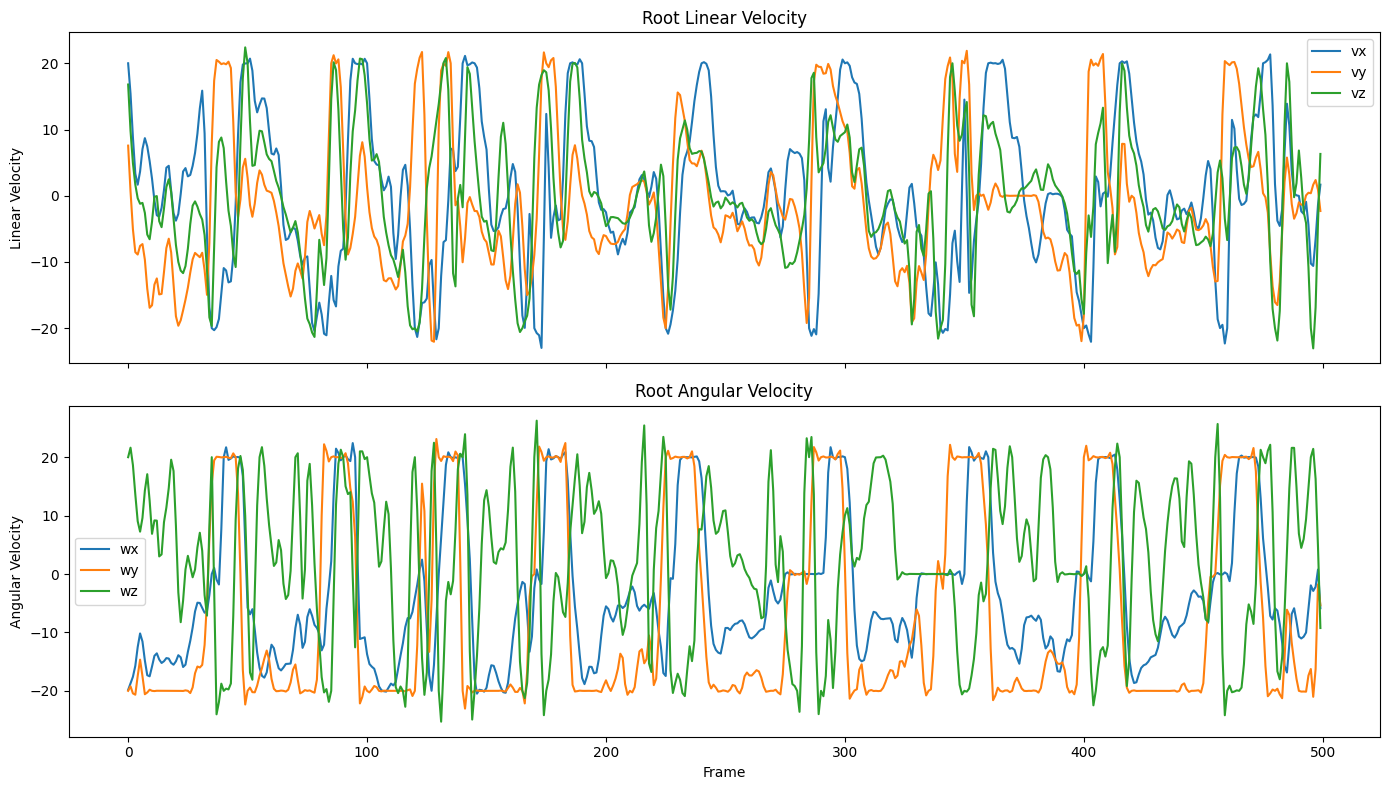

In [19]:
# Plot joint velocities if available
if qvel_final is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Linear velocity
    axes[0].plot(qvel_final[:clip_len, 0], label="vx")
    axes[0].plot(qvel_final[:clip_len, 1], label="vy")
    axes[0].plot(qvel_final[:clip_len, 2], label="vz")
    axes[0].set_ylabel("Linear Velocity")
    axes[0].set_title("Root Linear Velocity")
    axes[0].legend()

    # Angular velocity
    axes[1].plot(qvel_final[:clip_len, 3], label="wx")
    axes[1].plot(qvel_final[:clip_len, 4], label="wy")
    axes[1].plot(qvel_final[:clip_len, 5], label="wz")
    axes[1].set_xlabel("Frame")
    axes[1].set_ylabel("Angular Velocity")
    axes[1].set_title("Root Angular Velocity")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## 11. Export Final Results

In [20]:
# Get joint/body names from model for stac_io format
spec = mujoco.MjSpec().from_file(str(MODEL_XML_PATH))

# Get qpos names (joint names, with 'root' repeated for freejoint components)
names_qpos = []
for joint in spec.joints:
    if "free" in joint.name.lower():
        # Freejoint has 7 components (3 pos + 4 quat)
        names_qpos.extend(["root"] * 7)
    else:
        names_qpos.append(joint.name)

# Get body names for xpos
names_xpos = [body.name for body in spec.bodies]

print(f"names_qpos: {len(names_qpos)} entries")
print(f"names_xpos: {len(names_xpos)} entries")
print(f"kp_names: {len(kp_names)} entries")

names_qpos: 36 entries
names_xpos: 68 entries
kp_names: 30 entries


In [21]:
# Save IK results using stac_io.save_data_to_h5 for consistent format
print(f"Saving IK results to {IK_OUTPUT_PATH}...")

# Prepare kp_data in flattened format (T, N*3)
kp_data_final = (
    kp_data_flat[: qpos_final.shape[0]]
    if not (TARGET_HZ and TARGET_HZ != SOURCE_HZ)
    else None
)

# If interpolated, we need to interpolate kp_data too
if TARGET_HZ is not None and TARGET_HZ != SOURCE_HZ:
    kp_data_final = interpolate_to_frequency(kp_data_flat, SOURCE_HZ, TARGET_HZ)

# Prepare marker_sites if available, otherwise create placeholder
if hasattr(ik_data, "marker_sites") and ik_data.marker_sites is not None:
    marker_sites_final = np.array(ik_data.marker_sites)
    if TARGET_HZ is not None and TARGET_HZ != SOURCE_HZ:
        # Interpolate marker_sites
        ms_flat = marker_sites_final.reshape(marker_sites_final.shape[0], -1)
        ms_interp = interpolate_to_frequency(ms_flat, SOURCE_HZ, TARGET_HZ)
        marker_sites_final = ms_interp.reshape(-1, len(kp_names), 3)
else:
    # Create placeholder marker_sites with correct shape
    marker_sites_final = np.zeros((qpos_final.shape[0], len(kp_names), 3))

# Prepare qvel (use zeros if not computed)
if qvel_final is not None:
    qvel_save = qvel_final
else:
    qvel_save = np.zeros(
        (qpos_final.shape[0], qpos_final.shape[1] - 1)
    )  # nv = nq - 1 for freejoint

# Save using stac_io for consistent format
stac_io.save_data_to_h5(
    config=cfg,
    kp_names=kp_names,
    names_qpos=names_qpos,
    names_xpos=names_xpos,
    kp_data=kp_data_final,
    marker_sites=marker_sites_final,
    offsets=np.array(fit_data.offsets),
    qpos=qpos_final,
    xpos=xpos_final,
    xquat=xquat_final,
    qvel=qvel_save,
    file_path=str(IK_OUTPUT_PATH),
)

# Add clip_lengths as additional field (not part of standard stac_io format)
with h5py.File(str(IK_OUTPUT_PATH), "a") as f:
    # Recalculate clip lengths at output frequency
    if TARGET_HZ is not None and TARGET_HZ != SOURCE_HZ:
        clip_lengths_output = (clip_lengths * TARGET_HZ / SOURCE_HZ).astype(int)
    else:
        clip_lengths_output = clip_lengths

    # Save clip_lengths
    if "clip_lengths" in f:
        del f["clip_lengths"]
    f.create_dataset("clip_lengths", data=clip_lengths_output, compression="gzip")

    # Save frequency metadata as attributes
    f.attrs["source_hz"] = SOURCE_HZ
    f.attrs["output_hz"] = output_hz

print(f"Saved IK output using stac_io.save_data_to_h5!")
print(f"  Added clip_lengths: {clip_lengths_output.shape}")

Saving IK results to /home/talmolab/Desktop/SalkResearch/data/stac_ik_output_tethered_fly.h5...
Saved IK output using stac_io.save_data_to_h5!
  Added clip_lengths: (2713,)


In [22]:
# Verify saved file using stac_io.load_stac_data
print("\nVerifying saved IK output...")

loaded_cfg, loaded_data = stac_io.load_stac_data(str(IK_OUTPUT_PATH))

print(f"Loaded config type: {type(loaded_cfg)}")
print(f"\nLoaded data shapes:")
print(f"  qpos: {loaded_data.qpos.shape}")
print(f"  qvel: {loaded_data.qvel.shape}")
print(f"  xpos: {loaded_data.xpos.shape}")
print(f"  xquat: {loaded_data.xquat.shape}")
print(f"  kp_data: {loaded_data.kp_data.shape}")
print(f"  marker_sites: {loaded_data.marker_sites.shape}")
print(f"  offsets: {loaded_data.offsets.shape}")
print(f"  kp_names: {loaded_data.kp_names}")

print(f"\nOutput file: {IK_OUTPUT_PATH}")


Verifying saved IK output...
Loaded config type: <class 'omegaconf.dictconfig.DictConfig'>

Loaded data shapes:
  qpos: (692115, 36)
  qvel: (692115, 36)
  xpos: (692115, 68, 3)
  xquat: (692115, 68, 4)
  kp_data: (669781, 90)
  marker_sites: (692115, 30, 3)
  offsets: (30, 3)
  kp_names: ['L1A', 'L1B', 'L1C', 'L1D', 'L1E', 'R1A', 'R1B', 'R1C', 'R1D', 'R1E', 'L2A', 'L2B', 'L2C', 'L2D', 'L2E', 'R2A', 'R2B', 'R2C', 'R2D', 'R2E', 'L3A', 'L3B', 'L3C', 'L3D', 'L3E', 'R3A', 'R3B', 'R3C', 'R3D', 'R3E']

Output file: /home/talmolab/Desktop/SalkResearch/data/stac_ik_output_tethered_fly.h5


## 12. Optional: Render Sample Animation

In [23]:
qpos_final.shape

(692115, 36)

In [24]:
# Render a sample of the IK results
RENDER_SAMPLE = True
N_RENDER_FRAMES = 2000

if RENDER_SAMPLE:
    print(f"Rendering {N_RENDER_FRAMES} frames...")

    # Load model for rendering
    mj_model = mujoco.MjModel.from_xml_path(str(MODEL_XML_PATH))
    mj_data = mujoco.MjData(mj_model)

    # Setup renderer
    renderer = mujoco.Renderer(mj_model, width=640, height=480)

    frames = []
    for i in tqdm(range(min(N_RENDER_FRAMES, qpos_final.shape[0])), desc="Rendering"):
        # Set qpos
        mj_data.qpos[:] = qpos_final[i, : mj_model.nq]
        mujoco.mj_forward(mj_model, mj_data)

        # Render
        renderer.update_scene(mj_data, camera="track1")
        frame = renderer.render()
        frames.append(frame)

    renderer.close()

    # Display as video
    print("Displaying animation...")
    media.show_video(frames, fps=100)

Rendering 2000 frames...


Rendering: 100%|██████████| 2000/2000 [00:02<00:00, 675.79it/s]


Displaying animation...


## Summary

This notebook has:
1. Loaded Procrustes-aligned keypoints from Notebook 1
2. Configured and initialized STAC for the fly model
3. Fitted marker offsets using a subset of frames
4. Ran inverse kinematics on all frames to get joint angles
5. Computed joint velocities (optional)
6. Interpolated to higher frequency (optional)
7. Exported joint angles (qpos), velocities (qvel), and body positions (xpos) to H5

**Output files:**
- `stac_fit_offsets.h5`: Marker offset calibration results
- `stac_ik_output.h5`: Full IK results with qpos, qvel, xpos, xquat

In [25]:
import sys

sys.path.insert(0, "/home/talmolab/Desktop/SalkResearch/stac-mjx")

import h5py
import numpy as np
from stac_mjx import io as stac_io
from omegaconf import OmegaConf

# Load the rodent reference clips
input_path = "/home/talmolab/Desktop/SalkResearch/track-mjx/data/rodent/rodent_reference_clips.h5"

with h5py.File(input_path, "r") as f:
    print("Loading rodent reference clips...")
    print(f"Keys: {list(f.keys())}")

    # Load all data
    config_yaml = f["config"][()].decode("utf-8")
    kp_names = [name.decode("utf-8") for name in f["kp_names"][:]]
    names_qpos = [name.decode("utf-8") for name in f["names_qpos"][:]]
    names_xpos = [name.decode("utf-8") for name in f["names_xpos"][:]]
    kp_data = f["kp_data"][:]
    marker_sites = f["marker_sites"][:]
    offsets = f["offsets"][:]
    qpos = f["qpos"][:]
    qvel = f["qvel"][:]
    xpos = f["xpos"][:]
    xquat = f["xquat"][:]

print(f"\nData shapes:")
print(f"  kp_data: {kp_data.shape}")
print(f"  marker_sites: {marker_sites.shape}")
print(f"  offsets: {offsets.shape}")
print(f"  qpos: {qpos.shape}")
print(f"  qvel: {qvel.shape}")
print(f"  xpos: {xpos.shape}")
print(f"  xquat: {xquat.shape}")
print(f"\nKeypoint names: {kp_names}")

Loading rodent reference clips...
Keys: ['config', 'kp_data', 'kp_names', 'marker_sites', 'names_qpos', 'names_xpos', 'offsets', 'qpos', 'qvel', 'xpos', 'xquat']

Data shapes:
  kp_data: (210500, 69)
  marker_sites: (210500, 23, 3)
  offsets: (23, 3)
  qpos: (210500, 74)
  qvel: (210500, 73)
  xpos: (210500, 67, 3)
  xquat: (210500, 67, 4)

Keypoint names: ['AnkleL', 'AnkleR', 'EarL', 'EarR', 'ElbowL', 'ElbowR', 'FootL', 'FootR', 'HandL', 'HandR', 'HipL', 'HipR', 'KneeL', 'KneeR', 'ShoulderL', 'ShoulderR', 'Snout', 'SpineF', 'SpineL', 'SpineM', 'TailBase', 'WristL', 'WristR']
